**THIS CHAPTER IS CURRENTLY UNDER CONSTRUCTION!!!**

(information-theory)=
# Information theory

This chapter marks a pivotal shift in the book, moving from our focused exploration of abstract probability theory to practicalities of building and training probabilistic models. Subsequent chapters construct estimators and statistics and develop their theories, all of this with the overarching goal of leveraging these newfound tools to discover answers to specific questions or inquiries of particular interest. Most texts on mathematical statistics make a similar transition to similar material that they call _inferential statistics_---but whatever it might be called, we are trying to do the same thing: _Learn from data_.

The current chapter describes tools and techniques drawn from the _theory of information_, which is a charming amalgamation of practical engineering and theoretical mathematics. Among other things, this theory provides us with a method for measuring a particular form of _information_, but it also gives us techniques for quantifying related degrees of _surprise_, _uncertainty_, and _entropy_. In the upcoming chapters, our primary use for these measures will be to train and choose probabilistic models, but the theory reaches way beyond into physics, coding theory, computer science, neuroscience, biology, economics, the theory of complex systems, and even philosophy.

We will begin the chapter with a motivational section to help introduce the very specific type of _information_ that this theory purports to study. While the hurried reader may skip this initial section if they so choose, they should also be warned that the abstract definitions in later sections will be quite difficult to "grok" at first sight without the context and setting provided by the first section. Throughout the remaining sections in the chapter, we will try to hit many of the highlights of the theory, but we will fall well short of comprehensive coverage. But fortunately, there are several textbook-length treatments of information theory that are very approachable---the standard references are {cite}`CoverThomas2006` and {cite}`MacKay2003`. I also quite enjoy {cite}`Ash2012`, though it is much older than the other two references and is written in the definition-theorem-proof style of pure mathematics (which some appreciate, some don't).










## Preview: How do we measure information?

The word _information_ is often used in different contexts to mean different things. We all have some intuitive sense for what the term means, but it is a notoriously difficult thing to nail down _precisely_---no single definition seems to exist that covers _all_ the ways in which it is used. Both professional philosophers (which I am not) and amateur armchair philosophers (which I am) like to argue about it. The fastest way for someone to tell you that they have no clue what information is, is to tell you that they know what information is.

This being said, one of the central quantities that we will define (precisely!) and study in this chapter is something called _Shannon information_. The name comes from Claude Shannon, who is credited with laying down most of the foundations of the mathematical theory of information in {cite}`Shannon1948`, though he referred to it as the mathematical theory of _communication_. Indeed, on this point I cannot resist quoting another one of the pioneers of the field, Robert Fano:

```{margin}

This is the same quote that opens the fantastic survey article {cite}`Rioul2021` on information theory, which I enthusiastically recommend. I learned of this quote from that article.
```

```{epigraph}
"I didn’t like the term 'information theory.' Claude [Shannon] didn’t like it either. You see, the term 'information theory' suggests that it is a theory about information—--but it’s not. It’s the transmission of information, not information. Lots of people just didn’t understand this."
```

Despite these misgivings from the founders, the terms _information theory_ and _Shannon information_ have stuck, and that's what we will call them. Once you learn the precise definition of _Shannon information_, it will be up to you to decide if it comports with and captures your prior intuitive understanding of "information."

At first blush, you might imagine that this _information_ resides in data, but that's not true. Rather, this particular form of _information_ is initially attached to our _beliefs_ about the data---or, more precisely, this _information_ is associated with a probabilistic model of the data. But if we have successfully cooked up a model that we think truly captures the data, then this form of _information_ might (with caution!) be transferred from the model and attributed to the data. In any case, it's a point that you would do well to remember: _Information-theoretic measures are associated with models, not datasets!_

To give you an initial sense of how this special notion of _information_ arises, let's go through a simple and concrete example. Let's suppose that we have three simple data sources that produce bit strings, or strings of $0$'s and $1$'s. (Bit $=$ binary digit.) We will assign them the names Source 1, Source 2, and Source 3, and we then collect data:

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import huffman
from itertools import product
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.style.use('../aux-files/custom_style_light.mplstyle')
blue = '#486AFB'
magenta = '#FD46FC'

def generate_data(theta, block_length, message_length, random_state=None):
    if random_state != None:
        np.random.seed(random_state)
    num_bits = block_length * message_length
    n1 = int(theta * num_bits)
    n0 = int((1 - theta) * num_bits)
    ones = np.ones(n1, dtype=int)
    zeros = np.zeros(n0, dtype=int)
    data = np.concatenate((ones, zeros))
    np.random.shuffle(data)
    data_string = ''.join([str(num) for num in data])
    data_blocks = [data_string[i:i+block_length] for i in range(0, num_bits, block_length)]
    return data_string, data_blocks

block_length = 5
num_bits = 500
theta1 = 0.1
theta2 = 0.2
theta3 = 0.5
message_length = num_bits // block_length

data1_string, data1 = generate_data(theta=theta1, block_length=block_length, message_length=message_length, random_state=42)
data2_string, data2 = generate_data(theta=theta2, block_length=block_length, message_length=message_length, random_state=42)
data3_string, data3 = generate_data(theta=theta3, block_length=block_length, message_length=message_length, random_state=42)

print('Data 1: ', data1_string)
print('Data 2: ', data2_string)
print('Data 3: ', data3_string)

Data 1:  00000000001000000100000000000000001000000000101101000000010000000101000000000000000000000000000000010010000000000100000100000000001000000110000000100010110010000001001100100000000000000000000000000000000000000000000000000010000000000100000000010001000000000000000000000000000000000000000000000000000000000000000000000000001000000001110000000000010000001000000000001100001000000000001000010100000000000000000000010000000010010001000000000010000000000000000000000010001000000000000000000000000010000000
Data 2:  0100000010100100010000001000000000100101010011110110000101010000110100000000010001000100000000001101001001000000010000010000000000100001011010010010001011001001000100110010000000000000000100000000010001000001000000000000001000000101010000000001001100000000000000010001000000000000000000000000000000000000000000000000000000101010000111000001100001000000100000001001110000100000001000100101010000000000000000000001000000101001010100010010001010000000000101000000011000100000000000000

Each string is 500 bits long.

Models are suggested through the identification of patterns, regularities, and other types of special and particular structure. But when you scroll through the bit strings, it appears that the $0$'s and $1$'s are produced by the three sources in a random and haphazard manner; there are no detectable _deterministic_ regularities. But probabilistic models are not built to capture such regularities, so this should not worry us; rather, such models are designed to capture _probabilistic_ or _statistical_ properties.

We _do_ notice that the relative frequency of $1$'s appears to increase as we go from the first bit string, to the second, to the third. With this in mind, we ask the machine to compute these frequencies:

In [2]:
n1 = data1_string.count('1')
print(f"Relative frequency of 1's for data 1:  {n1 / num_bits:0.2f}")

n1 = data2_string.count('1')
print(f"Relative frequency of 1's for data 2:  {n1 / num_bits:0.2f}")

n1 = data3_string.count('1')
print(f"Relative frequency of 1's for data 3:  {n1 / num_bits:0.2f}")

Relative frequency of 1's for data 1:  0.10
Relative frequency of 1's for data 2:  0.20
Relative frequency of 1's for data 3:  0.50


These values immediately suggest the models: Source 1, 2, and 3 will be modeled, respectively, by the random variables

$$
X_1 \sim \Ber(0.1), \quad X_2 \sim \Ber(0.2), \quad \text{and} \quad X_3 \sim \Ber(0.5).
$$

We conceptualize the bit strings as subsequent draws from these random variables, each bit in the string being produced independently of all those that came before it.

Now we ask the central question: Using these models, how might we measure or quantify the _information_ contained in each bit string? (Take care to notice that we are asking this question only _after_ we have chosen probabilistic models, not _before_. Indeed, in accord with what we mentioned above, the notion of _information_ that we are ultimately after is a feature of the model, _not_ the raw data.)

Of course, the question is hopelessly unanswerable, because _information_ is as yet undefined. But instead of trying to find some abstract and highfalutin description that _directly_ aims to characterize _information_ in all its diverse manifestations, we seek some sort of proxy that allows us to _indirectly_ "get at" this slippery notion.

One such proxy is inspired and motivated by practical engineering considerations: The information content in these strings should be related to our ability to losslessly _compress_ the strings. Indeed, a larger compression ratio (i.e., the number of original bits to the number of compressed bits) should reflect that the string contains little information, while a smaller compression ratio should mean the opposite. As an extreme example, think of the bit string consisting of exactly five hundred $1$'s; we might imagine that it is the output of a fourth data source modeled via the random(?) variable $X_4 \sim \Ber(1)$. Intuitively, there is little information content carried by such a string, which is reflected in the fact that it may be highly compressed: If we design an encoding scheme with _block length_ equal to $500$ (see below), then this string would be compressed to the length-$1$ string consisting of just the single bit $1$. This is a $500$ to $1$ compression factor---quite large indeed!

How do the probabilistic models fit into these considerations? Remember, the models were chosen to capture statistical properties of the bit strings. We can take advantage of these properties by splitting the strings into substrings of a specified _block length_; for example, if we use a block length of $5$, we get:

In [3]:
print('Data 1: ', data1)
print('Data 2: ', data2)
print('Data 3: ', data3)

Data 1:  ['00000', '00000', '10000', '00100', '00000', '00000', '00001', '00000', '00001', '01101', '00000', '00100', '00000', '10100', '00000', '00000', '00000', '00000', '00000', '00001', '00100', '00000', '00010', '00001', '00000', '00000', '10000', '00110', '00000', '01000', '10110', '01000', '00010', '01100', '10000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00100', '00000', '00010', '00000', '00010', '00100', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00100', '00000', '01110', '00000', '00000', '10000', '00100', '00000', '00001', '10000', '10000', '00000', '00100', '00101', '00000', '00000', '00000', '00000', '01000', '00000', '10010', '00100', '00000', '00010', '00000', '00000', '00000', '00000', '00100', '01000', '00000', '00000', '00000', '00000', '00100', '00000']
Data 2:  ['01000', '00010', '10010', '00100', '00001', '00000', '00001', '00101', '01001',

The third model $X_3 \sim \Bin(0.5)$ tells us that any given block is just as likely to appear in the data as any other; however, the first and second models $X_1 \sim \Bin(0.1)$ and $X_2 \sim \Ber(0.2)$ assign different probabilities to observing one or the other of the two bits $0$ and $1$, and therefore certain blocks in their data strings are more likely to appear than others. So then the idea is simple: To compress the first two strings, we assign short code words to blocks that are more likely to appear according to the models.

One routine to find suitably short code words is called _Huffman coding_ which, conveniently, may be easily implemented in Python. The following code cell contains dictionaries representing the codebooks obtained by running this routine on the three data strings. The keys to the dictionaries consist of all $2^5 = 32$ possible blocks, while the values are the code words.

In [4]:
strings = [''.join([str(tup[i]) for i in range(block_length)]) for tup in product(range(2), repeat=block_length)]

def generate_codebook(theta):
    prob_dist = {}
    for string in strings:
        n1 = string.count('1')
        n0 = block_length - n1
        prob = (theta ** n1) * ((1 - theta) ** n0)
        prob_dist = prob_dist | {string: prob}
    codebook = huffman.codebook(prob_dist.items())
    return codebook, prob_dist

codebook1, prob_dist1 = generate_codebook(theta=theta1)
codebook2, prob_dist2 = generate_codebook(theta=theta2)
codebook3, prob_dist3 = generate_codebook(theta=theta3)

spaced_codebook1 = {}
spaced_codebook2 = {}
spaced_codebook3 = {}

for block in strings:
    n1 = len(codebook1[block])
    n2 = len(codebook2[block])
    n3 = len(codebook3[block])
    max_n = max([n1, n2, n3])
    d1 = max_n - n1
    d2 = max_n - n2
    d3 = max_n - n3
    blanks1 = (' ' * d1)
    blanks2 = (' ' * d2)
    blanks3 = (' ' * d3)
    spaced_codebook1 = spaced_codebook1 | {block: blanks1 + codebook1[block]}
    spaced_codebook2 = spaced_codebook2 | {block: blanks2 + codebook2[block]}
    spaced_codebook3 = spaced_codebook3 | {block: blanks3 + codebook3[block]}

print('Codebook 1: ', spaced_codebook1)
print('Codebook 2: ', spaced_codebook2)
print('Codebook 3: ', spaced_codebook3)

Codebook 1:  {'00000': '    1', '00001': '  000', '00010': ' 0110', '00011': '0011111', '00100': ' 0101', '00101': '0011011', '00110': '0011101', '00111': '001100100', '01000': ' 0100', '01001': '001001', '01010': '001011', '01011': '001100000', '01100': '0011100', '01101': '0011001110', '01110': '0011001011', '01111': '001100101001', '10000': ' 0111', '10001': '001010', '10010': '0011110', '10011': '001100011', '10100': '0011010', '10101': '001100010', '10110': '001100001', '10111': '001100101000', '11000': '001000', '11001': '0011001101', '11010': '0011001111', '11011': '0011001010111', '11100': '0011001100', '11101': '0011001010110', '11110': '0011001010101', '11111': '0011001010100'}
Codebook 2:  {'00000': '   11', '00001': ' 1000', '00010': '  001', '00011': '  01110', '00100': ' 1010', '00101': '  01001', '00110': '  01011', '00111': '  0101011', '01000': '  000', '01001': ' 01101', '01010': '100100', '01011': '  0110011', '01100': ' 011111', '01101': '  01111011', '01110': '  01

In the first codebook, notice that the blocks `00000` and `11111` are assigned, respectively, the code words `1` and `0011001010100`. The difference in length of the code words reflects the difference in probability of observing the two blocks, $0.9^5 \approx 0.59$ for the first versus $0.1^5 \approx 10^{-5}$ for the second. We print out the original blocks and their code words in the next cell, along with average code word lengths and reciprocal compression factors:

In [5]:
def compress_data(data, codebook):

    compressed_data = [codebook[word] for word in data]
    data_spaced = []
    compressed_data_spaced = []

    for block, compressed_block in zip(data, compressed_data):
        diff = len(block) - len(compressed_block)
        if diff >= 0:
            blanks = (' ' * diff)
            data_spaced.append(block)
            compressed_data_spaced.append(blanks + compressed_block)
        else:
            blanks = (' ' * -diff)
            data_spaced.append(blanks + block)
            compressed_data_spaced.append(compressed_block)
    
    return compressed_data, data_spaced, compressed_data_spaced

compressed_data1, data1_spaced, compressed_data1_spaced = compress_data(data=data1, codebook=codebook1)
compressed_data2, data2_spaced, compressed_data2_spaced = compress_data(data=data2, codebook=codebook2)
compressed_data3, data3_spaced, compressed_data3_spaced = compress_data(data=data3, codebook=codebook3)

print('|---------- Data 1 ----------|')

avg_length = sum([len(codeword) for codeword in compressed_data1]) / len(compressed_data1)

print('Data:                         ', data1_spaced)
print('Compressed data:              ', compressed_data1_spaced)
print('Average code word length:     ', avg_length)
print('Reciprocal compression factor:', avg_length, "/", block_length, '=', avg_length / block_length)

print('\n')

print('|---------- Data 2 ----------|')

avg_length = sum([len(codeword) for codeword in compressed_data2]) / len(compressed_data2)

print('Data:                         ', data2_spaced)
print('Compressed data:              ', compressed_data2_spaced)
print('Average code word length:     ', avg_length)
print('Reciprocal compression factor:', avg_length, "/", block_length, '=', avg_length / block_length)

print('\n')

print('|---------- Data 3 ----------|')

avg_length = sum([len(codeword) for codeword in compressed_data3]) / len(compressed_data3)

print('Data:                         ', data3_spaced)
print('Compressed data:              ', compressed_data3_spaced)
print('Average code word length:     ', avg_length)
print('Reciprocal compression factor:', avg_length, "/", block_length, '=', avg_length / block_length)

|---------- Data 1 ----------|
Data:                          ['00000', '00000', '10000', '00100', '00000', '00000', '00001', '00000', '00001', '     01101', '00000', '00100', '00000', '  10100', '00000', '00000', '00000', '00000', '00000', '00001', '00100', '00000', '00010', '00001', '00000', '00000', '10000', '  00110', '00000', '01000', '    10110', '01000', '00010', '  01100', '10000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00100', '00000', '00010', '00000', '00010', '00100', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00100', '00000', '     01110', '00000', '00000', '10000', '00100', '00000', '00001', '10000', '10000', '00000', '00100', '  00101', '00000', '00000', '00000', '00000', '01000', '00000', '  10010', '00100', '00000', '00010', '00000', '00000', '00000', '00000', '00100', '01000', '00000', '00000', '00000', '00000', '00100', '00000']
Compressed da

To help interpret these results, it will be useful to summarize the discussion so far:

> Probabilistic models capture statistical and probabilistic properties in data. Expressed through the model, these properties allow us to design coding schemes that _compress_ the data---a larger compression ratio should stand in as a proxy for lower "information content" carried by the data. Different models will lead to different compression ratios, and therefore different measures of "information content." So it is important to remember: In this scheme, _"information content" is not intrinsic to data!_

So, the average code word lengths and reciprocal compression factors displayed in the last printout depend on _two_ things: Both the chosen probabilistic models and the particular coding schemes (in this case, Huffman coding). However, one of the central contributions of information theory shows that there are _minimal_ average reciprocal compression factors that depend _only_ on the underlying probabilistic models; these mean values are called the _(Shannon) entropies_ of the models. Moreover, it is a _theorem_ in information theory that Huffman codes yield reciprocal compression factors that get at least as close to these entropies as any other code (at least restricted to so-called _prefix-free_ codes). Thus, the reciprocal compression factors displayed above may be considered approximations of the entropies of the underlying models. If we believe that high (low) compression factors signal lower (higher) information content, then small (large) entropies should serve as a proxy for low (high) information content.

Our three probabilistic models are particular examples of the general Bernoulli model $X\sim \Ber(\theta)$ for $\theta \in[0,1]$. The model depends only on the parameter $\theta$, and thus so too does its entropy. In the next section, we will see a simple formula for this entropy; if use this formula to plot entropy against $\theta$, we get this:

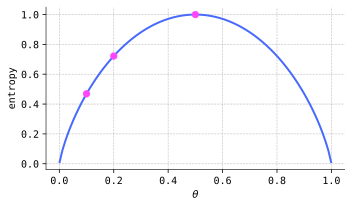

In [6]:
def bernoulli_entropy(theta, phi=None):
    if phi != None:
        return -theta * np.log2(phi) - (1 - theta) * np.log2(1 - phi)
    else:
        return -theta * np.log2(theta) - (1 - theta) * np.log2(1 - theta)
    
grid = np.linspace(0.001, 0.999, 100)
plt.plot(grid, bernoulli_entropy(grid))
plt.scatter(0.1, bernoulli_entropy(0.1), color=magenta, s=50, zorder=2)
plt.scatter(0.2, bernoulli_entropy(0.2), color=magenta, s=50, zorder=2)
plt.scatter(0.5, bernoulli_entropy(0.5), color=magenta, s=50, zorder=2)
plt.gcf().set_size_inches(w=5, h=3)
plt.xlabel('$\\theta$')
plt.ylabel('entropy')
plt.tight_layout()

The three dots are at parameter values $\theta=0.1, 0.2, 0.5$; notice that the corresponding entropies are very near the (reciprocal) compression factors identified above. Notice also that the entropy is maximized at $\theta=0.5$, so the data strings that carry the most average information content are those drawn from a Bernoulli model where we have an equal chance of observing a $0$ or $1$; in other words, the data strings where the identity of each individual bit is the _most uncertain_ are those that carry the most information content. This identification between high uncertainty and high information content is confusing at first glance, and we will touch on this point again briefly in the next section.

---

As I mentioned at the beginning of this section, we shall primarily use information-theoretic methods as means to train and choose between probabilistic models. This implies, of course, that there is some way to _compare_ models using these methods. Before moving on to the next section, I want to show you how these methods might work using our three toy models above, while also introducing some more of the main players in information theory.

Sometimes it is a convenient fiction to posit the existence of a "true" probabilistic model that generates observed data. Putting aside whatever philosophical issues you might have regarding this claim, perhaps you will agree that our three toy models come as near to these "true" models as any other. What were to happen, then, if I encoded the first bit string using the codebook from the second bit string? Or, in other words, what if I _misidentified_ the parameter for the first model as $\theta=0.2$, when it is "truly" supposed to be $\theta=0.1$?

The Huffman codes obtained from the "true" models were optimized, in the sense that they came closest to achieving the theoretical lower bounds on reciprocal data compression factors given by the entropies of the "true" models. This suggests that if we use the _wrong_ code, we should see worse performance on these compression metrics. The following code cell gives the results of using the codebook for the "wrong" parameter $\theta=0.2$ to encode the first data string:

In [7]:
wrong_compressed_data1, data1_spaced, wrong_compressed_data1_spaced = compress_data(data=data1, codebook=codebook2)

avg_length = sum([len(codeword) for codeword in wrong_compressed_data1]) / len(wrong_compressed_data1)

print('|---- Data 1 (wrong model) ----|')
print('Data:                           ', data1_spaced)
print('Compressed data:                ', wrong_compressed_data1_spaced)
print('Average code word length:       ', avg_length)
print('Reciprocal compression factor:  ', avg_length, "/", block_length, '=', avg_length / block_length)

|---- Data 1 (wrong model) ----|
Data:                            ['00000', '00000', '10000', '00100', '00000', '00000', '00001', '00000', '00001', '   01101', '00000', '00100', '00000', ' 10100', '00000', '00000', '00000', '00000', '00000', '00001', '00100', '00000', '00010', '00001', '00000', '00000', '10000', '00110', '00000', '01000', '  10110', '01000', '00010', ' 01100', '10000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00100', '00000', '00010', '00000', '00010', '00100', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00100', '00000', '   01110', '00000', '00000', '10000', '00100', '00000', '00001', '10000', '10000', '00000', '00100', '00101', '00000', '00000', '00000', '00000', '01000', '00000', ' 10010', '00100', '00000', '00010', '00000', '00000', '00000', '00000', '00100', '01000', '00000', '00000', '00000', '00000', '00100', '00000']
Compressed data:      

Comparing this to the optimal Huffman code above, we see that the reciprocal compression factor jumped from $0.488$ to $0.576$. At least in some sense, the difference between these two numbers serves as a proxy for the _discrepancy_ or _distance_ between the "true" model with $\theta=0.1$ and the "proposed" one with $\theta=0.2$.

Information theory not only provides the entropy of a single model, which is a theoretical lower bound on reciprocal compression factors, but it also provides the so-called _cross entropy_ between two models which provides a lower bound on the reciprocal compression factor when using the "wrong" code in place of the "true" one. A fundamental result in the theory is _Gibbs' Inequality_, which says that this cross entropy is always greater than or equal to the entropy of the "true" model; the difference between these two entropies is therefore a nonnegative number that provides a measure of _distance_ between a "proposed" (perhaps "wrong") model and the "true" one. This difference is known as the _Kullback Leibler (KL) divergence_. By Gibbs' Inequality, the KL divergence achieves its global minimum value (i.e., $0$) when the "proposed" model is equal to the "true" one. These cross entropies and KL divergences will play a crucial role throughout the next few chapters.














## Shannon information and entropy

Our development of the theory begins with:

```{prf:definition}
:label: info-content-def

Let $P$ be a probability measure on a finite sample space $S$ with mass function $p(s)$. The _(Shannon) information content_ of the sample point $s\in S$, denoted $I_P(s)$, is defined to be

$$
I_P(s) \def - \log_2(p(s)).
$$

The information content is also called the _surprisal_. If $p(s) =0$, we set $I_P(s) = \infty$.

If the probability measure $P$ is clear from context, we will write $I(s)$ in place of $I_P(s)$. If $\bX$ is a random vector with finite range and probability measure $P_\bX$, we will write $I_\bX(\bx)$ in place of $I_{P_\bX}(\bx)$.
```

Please understand that the terminology _information content_ now has a very specific and precise mathematical meaning. It is designed to "get at" our intuitive understanding of what general "information" is, but you should keep the two separate in your mind: There's the notion of "information" used in an intuitive and colloquial sense and is generally ill-defined, and then there is the notion of _information content_ precisely defined as above.

The exact relationship between information content and the coding considerations from the previous section will be explained later. The alternate moniker _surprisal_, however, may be explained very nicely by simply inspecting the graph of the negative logarithm function:

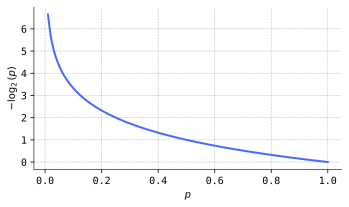

In [8]:
grid = np.linspace(0.01, 1, 100)
plt.plot(grid, -np.log2(grid))
plt.xlabel('$p$')
plt.ylabel('$-\\log_2(p)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

Thus, the larger the probability $p$, the smaller the surprisal: If some outcome is highly likely to occur, then it is not surprising. In the other direction, if an outcome $s$ is highly unlikely to occur (small $p(s)$), then it is very surprising (large $I(s)$).

It might occur that there are many functions that are equally capable of expressing this same inverse relationship between probability and surprisal---so why the choice of base-$2$ logarithm? It turns out that if you begin from first principles with a set of "natural axioms" that any notion of _surprisal_ should possess, then you can _prove_ all such surprisal functions must be proportional to negative logarithms; see, for example, the discussion in Section 9 in {cite}`Rioul2021`. The choice of base $2$ is then somewhat arbitrary, akin to choosing units, but it does have the added benefit of nicely connecting up with bit strings in the coding context. Indeed, in base $2$, information content is measured in units of _bits_. While this is related to the previous notion of a bit denoting a binary digit ($0$ or $1$), the usage here is different, at the very least because information content does not have to be an integer. (See Section 10 in the aforementioned reference {cite}`Rioul2021` for more on units.)

With the information content (or surprisal) in hand, we now define _entropy_:

```{prf:definition}
:label: entropy-def

Let $P$ be a probability measure on a finite sample space $S$ with mass function $p(s)$. The _(Shannon) entropy_ of $P$, denoted $H(P)$, is defined to be

$$
H(P) \def \sum_{s\in S} p(s)I_P(s).
$$

The entropy is also called the _uncertainty_.

If $\bX$ is a random vector with finite range and probability measure $P_\bX$, we will write $H(\bX)$ in place of $H(P_\bX)$. If we write the vector in terms of its component random variables $\bX = (X_1,\ldots,X_m)$, then we shall also write $H(X_1,\ldots,X_m)$ in place of $H(P_\bX)$ and call this the _joint entropy_ of the random variables $X_1,\ldots,X_m$.
```

Since $I(s) = -\log_2(p(s))$, there is an issue in the definition of $H(P)$ in the case that $p(s)=0$ for some $s\in S$, for then we encounter the indeterminate form $0 \log_2(0)$. By convention, we take this expression to equal $0$, which may be justified according to the limit

$$
\lim_{p \to 0^+} p \log_2(p) = 0.
$$

Notice that the entropy is the average information content, or surprisal, where the averaging weights are drawn from the mass function $p(s)$. Since averages of this form will reoccur so often in the current and next few chapters, it will be convenient to introduce new notations for them. So, if $P$ is a discrete probability measure with mass function $p(s)$ on a sample space $S$ and $g:S\to \bbr$ is a real-valued function, we will define

$$
E_P\left[g(s)\right] \def \sum_{s\in S} g(s) p(s).
$$

Alternatively, if we want to explicitly call attention to the mass function $p(s)$ rather than the probability measure $P$ itself, we will write

$$
E_{s\sim p(s)}\left[g(s)\right] \def \sum_{s\in S} g(s) p(s).
$$

We refer to these sums as the _mean value_ or _expected value_ of $g(s)$. Note that these are legitimately new usages of the expectation symbol $E$, since there is no random variable given _a priori_. To see the connection with the previous usage of $E$ for a discrete random variable $X$ with mass function $p_X(x)$, suppose that $g:\bbr \to \bbr$ and note

$$
E_{P_X}\left[g(x)\right] = \sum_{x\in \bbr}g(x) p_X(x) = E\left[g(X)\right].
$$

Indeed, the first equality follows from the definition of $E_{P_X}\left[g(x)\right]$ given above, while the second equality follows from the LotUS. Using this new notation, the definition of entropy may be rewritten as

$$
H(P) = E_P\left[I_P(s)\right] = E_{s\sim p(s)} \left[ I_P(s)\right].
$$

```{admonition} Problem Prompt

Do problems 1 and 2 on the worksheet.
```

Now comes the fundamental notion of _cross entropy_, which we briefly met at the end of the previous section:

```{prf:definition}
:label: cross-entropy-def

Let $P$ and $Q$ be two probability measures on a finite sample space $S$ with mass functions $p(s)$ and $q(s)$. Suppose they satisfy the following condition:

* _Absolute continuity_. For all $s\in S$, if $q(s)=0$, then $p(s) = 0$. Or equivalently, the support of $q(s)$ contains the support of $p(s)$.

Then the _cross entropy_ from $P$ to $Q$, denoted $H(P \parallel Q)$, is defined by

$$
H(P \parallel Q) \def E_{s\sim p(s)}\left[ I_Q(s) \right] =  - \sum_{s\in S} p(s)\log_2(q(s)).
$$

As usual, if $P_\bX$ and $P_\bY$ are the probability measures of two random vectors $\bX$ and $\bY$ with finite ranges, we will write $H(\bY \parallel \bX)$ in place of $H(P_\bY \parallel P_\bX)$.
```

Notice that the condition of absolute continuity between the two measures guarantees we will never see an expression of the form $p \log_2(0)$, with $p \neq 0$. Thus, it is enough to make the cross entropy well-defined by stipulating that we take $0 \log_2(0) =0$, as explained above.

```{admonition} Problem Prompt

Do problem 3 on the worksheet.
```





## KL divergence

The types of measures $P$ and $Q$ that we shall work with initially are ones defined on a finite probability space $S$, so that they have mass functions $p(s)$ and $q(s)$ with finite support. The basic measure that we use in this chapter to compare them is the mean logarithmic relative magnitude. 

```{margin}

Of course, the two notions of _absolute relative magnitude_ and _logarithmic relative magnitude_ make sense for any pair of numbers, not necessarily probabilities.
```

Precisely, the _absolute relative magnitude_ of the probability $p(s)$ to the probability $q(s)$ ordinarily refers to the ratio $p(s)/q(s)$, while the _logarithmic relative magnitude_ refers to the base-$10$ logarithm of the absolute relative magnitude:

$$
\log_{10}\left( \frac{p(s)}{q(s)} \right).
$$

The intuition for this number is that it is the _order_ of the absolute relative magnitude; indeed, if we have $p(s) \approx 10^k$ and $q(s) \approx 10^l$, then the logarithmic relative magnitude is roughly the difference $k-l$.

Perhaps the most obvious immediate benefit of introducing the logarithm is that it yields a workable number when $p(s)$ and $q(s)$ are each on different scales. For example, let's suppose that the mass functions $p(s)$ and $q(s)$ are given by

$$
p(s) = \binom{10}{s} (0.4)^s(0.6)^{10-s} \quad \text{and} \quad q(s) = \binom{10}{s} (0.9)^s(0.1)^{10-s}
$$

for $s\in \{0,1,\ldots,10\}$; these are the mass functions of a $\Bin(10,0.4)$ and $\Bin(10,0.9)$ random variable, respectively. We then plot histograms for these mass functions, along with histograms of the absolute and logarithmic relative magnitudes:

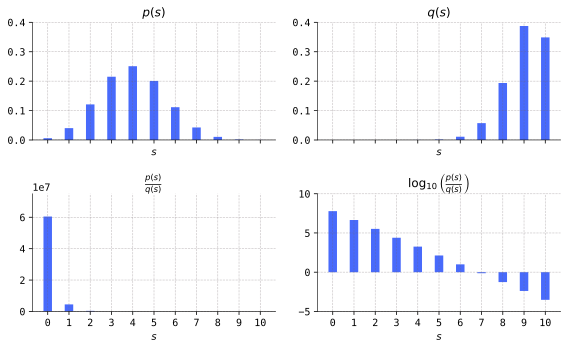

In [9]:
grid = np.arange(0, 11)
p = sp.stats.binom(n=10, p=0.4).pmf(grid)
q = sp.stats.binom(n=10, p=0.9).pmf(grid)
titles = ['$p(s)$',
          '$q(s)$',
          '$\\frac{p(s)}{q(s)}$',
          '$\\log_{10}\\left(\\frac{p(s)}{q(s)}\\right)$']
probs = [p,
         q,
         p / q,
         np.log10(p / q)]
ylims = [(0, 0.4),
         (0, 0.4),
         (-50, 0.75e8),
         (-5, 10)]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 5), sharex=True)

for title, prob, ylim, axis in zip(titles, probs, ylims, axes.flatten()):
    axis.bar(grid, prob, width=0.4)
    axis.set_xticks(ticks=grid)
    axis.set_ylim(ylim)
    axis.set_title(title)
    axis.set_xlabel('$s$')

plt.tight_layout()

The second row in the figure drives home the point: The absolute relative magnitudes are on such widely different scales that the plot is nearly useless and numerical computations in a machine will likely be unstable.

We obtain a single-number summary of the logarithmic relative magnitudes by averaging with weights drawn from the mass function $p(s)$; this yields the number

$$
\sum_{s\in S} p(s) \log_{10}\left( \frac{p(s)}{q(s)} \right).
$$ (first-kl-eq)

Observe that we could have drawn the averaging weights from the mass function $q(s)$ to instead obtain the single-number summary

$$
\sum_{s\in S} q(s) \log_{10}\left( \frac{p(s)}{q(s)} \right).
$$ (second-kl-eq)

But observe that

$$
\sum_{s\in S} q(s) \log_{10}\left( \frac{p(s)}{q(s)} \right) = - \sum_{s\in S} q(s) \log_{10}\left( \frac{q(s)}{p(s)} \right),
$$

where the right-hand side is the negative of a number of the form {eq}`first-kl-eq`. So, at least up to sign, it doesn't really matter which of the two numbers {eq}`first-kl-eq` or {eq}`second-kl-eq` we use to develop our theory. As we will see, our choice of {eq}`first-kl-eq` has the benefit of making the KL divergence nonnegative. Moreover, we can also alter the base of the logarithm in {eq}`first-kl-eq` without altering the core of the theory, since the change-of-base formula for logarithms tells us that the only difference is a multiplicative constant. In the following official definition, we will select the base-$2$ logarithm to make the later connections with bit strings in coding theory more transparent.

```{prf:definition}
:label: KL-def

Let $P$ and $Q$ be two probability measures on a finite sample space $S$ with mass functions $p(s)$ and $q(s)$. Suppose they satisfy the following condition:

* _Absolute continuity_. For all $s\in S$, if $q(s)=0$, then $p(s) = 0$. Or equivalently, the support of $q(s)$ contains the support of $p(s)$.

Then the _Kullback-Leibler divergence_ (or just _KL divergence_) from $P$ to $Q$, denoted $D(P \parallel Q)$, is the mean order of relative magnitude of $P$ to $Q$. Precisely, it is given by

$$
D(P \parallel Q) \def E_{s\sim p(s)} \left[ \log_2\left( \frac{p(s)}{q(s)} \right)\right] =  \sum_{s\in S} p(s) \log_2\left( \frac{p(s)}{q(s)} \right).
$$
```

```{admonition} Problem Prompt

To problem 4 on the worksheet.
```

The connection between KL divergence and entropy is given in the next theorem. Its proof is a triviality.

```{prf:theorem} KL divergence and entropy
:label: KL-and-entropy-thm

Let $P$ and $Q$ be two probability measures on a finite probability space $S$. Then

$$
D(P\parallel Q) = H(P \parallel Q) - H(P).
$$
```

The inequality in the first part of the following result is perhaps the most important in the foundations of the theory and ultimately justifies our conception of the KL divergence as a "directed distance" between two probability distributions. The second part shows that the maximum-entropy distributions are exactly the uniform ones.

```{prf:theorem} Optimization of KL divergences and entropies
:label: kl-entropy-optim-thm

Let $P$ and $Q$ be two probability measures on a finite probability space $S$.

1. _The Information Inequality_. We have

    $$
    D(P \parallel Q) = H(P \parallel Q) - H(P) \geq 0
    $$

    for all $P$ and $Q$, with equality if and only if $P=Q$.

2. We have 

    $$
    H(P) \leq \log_2{|S|}
    $$

    for all $P$, with equality if and only if $P$ is uniform.
```

```{prf:proof}
For the first part, suppose that $p_1,\ldots,p_n$ and $q_1,\ldots,q_n$ are numbers in $(0,1]$ such that

$$
\sum_{i=1}^n p_i = \sum_{i=1}^n q_i = 1.
$$ (constraint-lagrance-eq)

It will suffice, then, to show that the objective function

$$
J(q_1,\ldots,q_n) \def -\sum_{i=1}^n p_i \log_2{q_i},
$$

is globally minimized when $p_i = q_i$. But it is an easy exercise (using Lagrange multipliers) to show that a minimum can only occur when $p_i = q_i$ for each $i=1,\ldots,n$; one may confirm that this indeed yields a global maximum by showing that the objective function $J$ is convex (its Hessian matrix is positive definite) and noticing that the second constraint in {eq}`constraint-lagrance-eq` is affine. (See [here](https://math.stackexchange.com/a/1739181) for an explanation of the latter fact.) The proof of the second part follows the same pattern, with only the obvious changes. Q.E.D.
```

So, when $P$ is uniform, we have

$$
H(P) = \log_2|S|.
$$ (max-ent-eq)

It is pleasing to compare this maximum-entropy equation to the [Boltzmann equation](https://en.wikipedia.org/wiki/Boltzmann%27s_entropy_formula) for entropy in statistical mechanics. The definitional equation

$$
H(P) = - \sum_{s\in S} p(s) \log_2(p(s))
$$

is the analog of the [Gibbs equation](https://en.wikipedia.org/wiki/Entropy_(statistical_thermodynamics)#Gibbs_entropy_formula) for Boltzmann entropy.

In his initial paper, Shannon described entropy $H(P)$ as a measure of _uncertainty_. From this perspective, the rationale behind the maximum-entropy equation {eq}`max-ent-eq` becomes clear: If one were to randomly draw a number from a probability distribution, the uniform distribution is the one that would result in the highest level of uncertainty regarding the outcome.

























## Source coding

We now describe a coding-theoretic interpretation that sheds additional light on entropy and KL divergence. Rather than quantifying the degree of "uncertainty" present in a probability distribution, in this framework entropy gives a lower bound on the (average) minimum description length of the data modeled by a random variable or vector.

```{margin}

According to our definitions, technically the codomain of a random variable must be a subset of $\bbr$; but we can get around this minor annoyance by assuming that $a=1$, $b=2$, $c=3$, and $d=4$.
```

By way of introduction, suppose that $X$ is a discrete random variable with range $R = \{a,b,c,d\}$. Our goal is to construct an _encoding_ of $X$, by which we mean an assignment of a bit string to each symbol in $R$. For example, we might encode $X$ as

$$
a \leftrightarrow 00, \quad b \leftrightarrow 011, \quad c \leftrightarrow 10, \quad d \leftrightarrow 1100.
$$ (encoding-eqn)

We can _visualize_ this encoding by drawing a binary tree with five levels (including the root):

```{image} ../img/tree-01.svg
:width: 90%
:align: center
```
&nbsp;

To read this tree, begin at the root node at the top; then, follow the edges downward to find the nodes labeled by the symbols in $R$. A positively sloped edge represents a $0$, while a negatively edge represents a $1$. Thus, for example, to reach $d$ beginning from the root node, we follow edges labelled $1$, $1$, $0$, and $0$. This sequence of binary digits is exactly the code word for $d$, and thus paths through the tree represent code words. The numbered levels $\ell$ of the tree appear along the left-hand side of the figure; notice that these numbers are also the lengths of the code words.

Notice also that every path through the tree beginning at the root node and ending at a leaf in the lowest level contains at most one symbol in $R$. This is in contrast to the encoding of $X$ represented by the following tree:

```{image} ../img/tree-bad.svg
:width: 90%
:align: center
```
&nbsp;

with corresponding code words

$$
a \leftrightarrow 00, \quad b \leftrightarrow 001, \quad c \leftrightarrow 10, \quad d \leftrightarrow 1000.
$$

Indeed, in this latter encoding, there are _multiple_ paths from the top to the bottom level that contain more than one symbol in $R$. These paths manifest themselves as code words that are prefixes of other code words: The code word for $a$ appears as a prefix in the code word for $b$, and the code word for $c$ appears as a prefix in the code word for $d$. For this reason, encodings like the first {eq}`encoding-eqn` are called _prefix-free codes_.

Now, returning to our prefix-free code, consider the set of all descendants of symbols in $R$ that are in the lowest level, including any symbols in $R$ that happen to lie in the lowest level; these are all highlighted in:

```{image} ../img/tree-02.svg
:width: 90%
:align: center
```
&nbsp;

If a symbol in $R$ is on level $\ell_i$, then it has $4 - \ell_i$ descendents in the lowest level. Then obviously $\sum_{i=1}^4 2^{4-\ell_i} \leq 2^{4}$ (count the highlighted nodes!), and so

$$
\sum_{i=1}^4 2^{-\ell_i} \leq 1.
$$

In fact, this latter inequality should _always_ be true for _any_ encoding of $X$, provided that the code is prefix free. Can you see why?







## Mutual information



```{prf:definition}
:label: mutual-info-def

Let $\bX$ and $\bY$ be two random vectors with finite ranges. The *mutual information between $\bX$ and $\bY$* is the KL divergence

$$
I(\bX, \bY) \def D( P_{(\bX,\bY)} \parallel P_{\bX} P_{\bY}).
$$
```

```{prf:theorem} Mutual information and entropy
:label: other-info-thm

Let $\bX$ and $\bY$ be two random vectors with finite ranges. Then:

$$
I(\bX,\bY) = H(\bX) + H(\bY) - H(\bX,\bY).
$$
```

```{prf:proof}

The proof is a computation:

\begin{align*}
I(\bX,\bY) &= \sum_{\bx\in \bbr^n}\sum_{\by \in \bbr^m} p(\bx,\by) \log_2\left( \frac{p(\bx,\by)}{p(\bx)p(\by)} \right) \\
&= \sum_{\bx\in \bbr^n}\sum_{\by \in \bbr^m} p(\bx,\by) \log_2\left(p(\bx,\by)\right) - \sum_{\bx\in \bbr^n}\sum_{\by \in \bbr^m} p(\bx,\by) \log_2 \left(p(\bx)\right) \\
&\quad - \sum_{\bx\in \bbr^n}\sum_{\by \in \bbr^m} p(\bx,\by) \log_2\left(p(\by)\right) \\
&= - H(\bX,\bY) - \sum_{\bx \in \bbr^n} p(\bx) \log_2\left( p(\bx) \right) - \sum_{\by \in \bbr^m} p(\by) \log_2\left( p(\by)\right) \\
&= H(\bX) + H(\bY) - H(\bX, \bY),
\end{align*}

as desired. Q.E.D.
```